# Segmentation of Water Channels to Measure Water Contamination Due to Trash


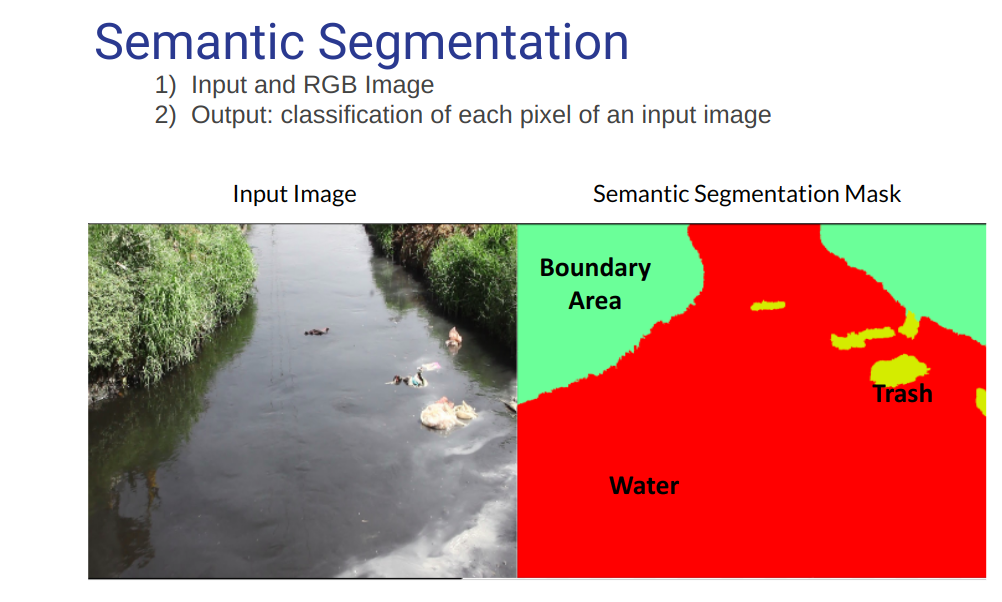# 

In [1]:
import keras
from keras.models import Model
from keras.layers import Input,SeparableConv2D
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Convolution2D
from tensorflow.keras.layers import BatchNormalization
import os, sys
import numpy as np
import cv2
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization,UpSampling2D,concatenate,Reshape
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical
import keras.backend as K
from keras.utils import  to_categorical
import keras
from keras import optimizers
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard


In [2]:


Beta=[0.011676873, 0.869083715, 0.119239412]
Beta= np.array(Beta)
#print(Beta)
def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def blance_loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight =Beta
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=pos_weight)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss *(Beta))


#Model
inputs = Input((256,256,3))
conv1 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
conv5 = SeparableConv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = SeparableConv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = SeparableConv2D(3, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv9)

model = Model(inputs,conv9)
model.compile(optimizer = Adam(lr = 1e-4), loss =blance_loss, metrics = ['accuracy'])



/Users/rafeyrana/miniconda3/envs/ML/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 64  283        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 256, 256, 64  4736       ['separable_conv2d[0][0]']       
 onv2D)                         )                                                             

In [4]:

model.load_weights('model.h5')

#https://github.com/fezancs/Segmentation_detection-Model/blob/master/model.h5

#model file can be downloaded from given link



In [5]:
def predict_(input_img):
    input_=np.array(cv2.imread(str(input_img)))
    input_ = cv2.resize(input_, (256,256), interpolation = cv2.INTER_NEAREST)
    input_=input_.reshape(1,256,256,3)
    input_=input_/255
    pre=model.predict(input_)
    pre=pre.reshape(256,256,3)
    pre=np.argmax(pre, axis=-1)
    label = keras.utils.to_categorical(pre,3)
    label[:,:,0]=label[:,:,1]
    label[:,:,2]=label[:,:,1]
    label=label*255
    plt.imshow(label.astype('uint8'))
    plt.show()


In [6]:
x_images_directory = "./Images/new_x_/"
image_files = [os.path.join(x_images_directory, filename) for filename in os.listdir(x_images_directory) if filename.endswith('.png')]

In [7]:
print(len(image_files))
random.shuffle(image_files)
test_images_for_parta = image_files[:10]
print(test_images_for_parta)

5349
['./Images/new_x_/4302.png', './Images/new_x_/5214.png', './Images/new_x_/3221.png', './Images/new_x_/742.png', './Images/new_x_/705.png', './Images/new_x_/1200.png', './Images/new_x_/2300.png', './Images/new_x_/1029.png', './Images/new_x_/189.png', './Images/new_x_/648.png']


2023-10-14 22:44:20.018607: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 470ms/step


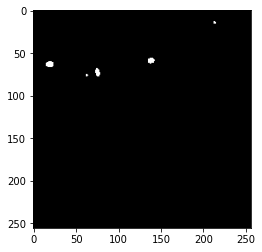

1/1 [==============================] - 0s 212ms/step


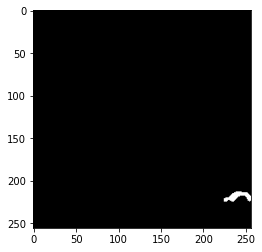

1/1 [==============================] - 0s 143ms/step


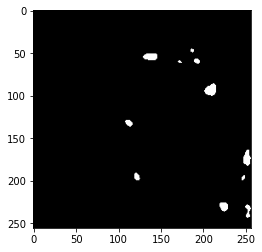

1/1 [==============================] - 0s 166ms/step


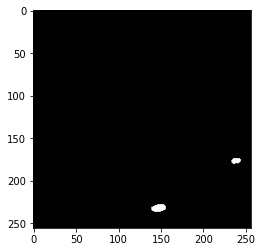

1/1 [==============================] - 0s 167ms/step


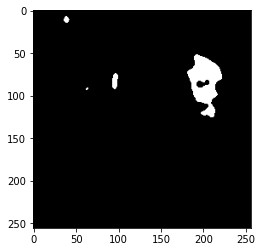

1/1 [==============================] - 0s 180ms/step


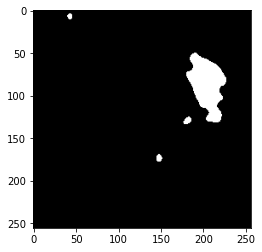

1/1 [==============================] - 0s 166ms/step


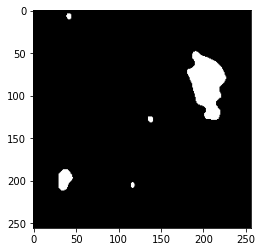

1/1 [==============================] - 0s 196ms/step


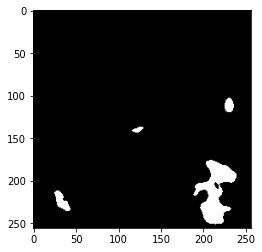

1/1 [==============================] - 0s 174ms/step


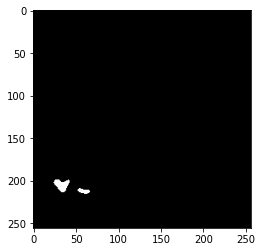

1/1 [==============================] - 0s 179ms/step


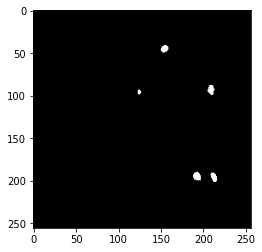

In [8]:
for item in test_images_for_parta:
    predict_(item)

In [9]:
x_images_directory = "./Images/new_x_/"
image_files = [os.path.join(x_images_directory, filename) for filename in os.listdir(x_images_directory) if filename.endswith('.png')]

In [10]:
print(len(os.listdir("Images/new_y_/")))

5350


In [11]:
def make_dataset(type_of_set_needed="", Image_folder="path_to_main_folder"):
    images_x = []
    images_y = []
    folder_x = os.path.join(Image_folder, "new_x_")
    folder_y = os.path.join(Image_folder, "new_y_")
    filenames_x = os.listdir(folder_x)
    num_samples = len(filenames_x)
    num_train = int(0.8 * num_samples)
    num_test = int(0.1 * num_samples)
    resize_shape = (64, 64)
    
    if type_of_set_needed == "train":
        for i, filename in enumerate(filenames_x):
            img_x = cv2.imread(os.path.join(folder_x, filename))
            img_y = cv2.imread(os.path.join(folder_y, filename))
            img_x = cv2.resize(img_x, resize_shape)
            img_y = cv2.resize(img_y, resize_shape)
            img_x = img_x / 255.0  
            img_y = img_y / 255.0  
            images_x.append(img_x)
            images_y.append(img_y)
            if i == num_train - 1:
                break
    elif type_of_set_needed == "test":
        for i, filename in enumerate(filenames_x[num_train:num_train+num_test]):
            img_x = cv2.imread(os.path.join(folder_x, filename))
            img_y = cv2.imread(os.path.join(folder_y, filename))
            img_x = cv2.resize(img_x, resize_shape)
            img_y = cv2.resize(img_y, resize_shape)
            img_x = img_x / 255.0  
            img_y = img_y / 255.0  
            images_x.append(img_x)
            images_y.append(img_y)
    elif type_of_set_needed == "validation":
        for i, filename in enumerate(filenames_x[num_train+num_test:]):
            img_x = cv2.imread(os.path.join(folder_x, filename))
            img_y = cv2.imread(os.path.join(folder_y, filename))
            img_x = cv2.resize(img_x, resize_shape)
            img_y = cv2.resize(img_y, resize_shape)
            img_x = img_x / 255.0  
            img_y = img_y / 255.0  
            images_x.append(img_x)
            images_y.append(img_y)
    
    return np.array(images_x), np.array(images_y)

In [12]:
train_x, train_y = make_dataset("train", "Images")

In [13]:
validate_x, validate_y = make_dataset("validation", "Images")

In [14]:
test_x , test_y = make_dataset("test","Images")

In [15]:
print(train_x[1].shape)

(64, 64, 3)


In [19]:


Beta=[0.011676873, 0.869083715, 0.119239412]
Beta= np.array(Beta)
#print(Beta)
def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def blance_loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight =Beta
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=tf.cast(y_true, tf.float32), pos_weight=pos_weight)
    return tf.reduce_mean(loss *(Beta))
def iou_metric(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    dice = (2.0 * intersection + smooth) / (K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) + smooth)
    return K.mean(dice, axis=0)



#Model
inputs = Input((64,64,3))
conv1 = SeparableConv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = SeparableConv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
conv5 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)
up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = SeparableConv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = SeparableConv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = SeparableConv2D(3, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv9)

segmentation_model = Model(inputs,conv9)
segmentation_model.compile(optimizer = Adam(lr = 1e-4), loss =blance_loss, metrics = ['accuracy', iou_metric, dice_coefficient])


In [18]:
# in case you dont want to train it again uncomment the following line
#segmentation_model.load_weights('model2_weights.h5')

In [20]:
segmentation_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 separable_conv2d_38 (Separable  (None, 64, 64, 32)  155         ['input_3[0][0]']                
 Conv2D)                                                                                          
                                                                                                  
 separable_conv2d_39 (Separable  (None, 64, 64, 32)  1344        ['separable_conv2d_38[0][0]']    
 Conv2D)                                                                                          
                                                                                            

In [21]:
print(train_x.shape)

(4279, 64, 64, 3)


In [22]:
history = segmentation_model.fit(
    train_x,
    train_y,
    batch_size=32,
    epochs=3,
    validation_data=(validate_x, validate_y),
)

Epoch 1/3
134/134 [==============================] - 79s 577ms/step - loss: 0.1336 - accuracy: 0.8950 - iou_metric: 0.0160 - dice_coefficient: 0.0308 - val_loss: 0.1298 - val_accuracy: 0.9010 - val_iou_metric: 0.0154 - val_dice_coefficient: 0.0297
Epoch 2/3
134/134 [==============================] - 68s 509ms/step - loss: 0.0872 - accuracy: 0.8971 - iou_metric: 0.0136 - dice_coefficient: 0.0262 - val_loss: 0.0259 - val_accuracy: 0.9012 - val_iou_metric: 0.0051 - val_dice_coefficient: 0.0099
Epoch 3/3
134/134 [==============================] - 72s 540ms/step - loss: 0.0262 - accuracy: 0.8973 - iou_metric: 0.0057 - dice_coefficient: 0.0111 - val_loss: 0.0251 - val_accuracy: 0.9012 - val_iou_metric: 0.0053 - val_dice_coefficient: 0.0102


In [23]:
history.history

{'loss': [0.1335783749818802, 0.08721762895584106, 0.02623498998582363],
 'accuracy': [0.8950292468070984, 0.8970864415168762, 0.8972856998443604],
 'iou_metric': [0.015994466841220856,
  0.013598120771348476,
  0.0057135955430567265],
 'dice_coefficient': [0.030765345320105553,
  0.02616177685558796,
  0.011065301485359669],
 'val_loss': [0.12983115017414093, 0.025912120938301086, 0.025137444958090782],
 'val_accuracy': [0.9009749889373779, 0.9012177586555481, 0.9012177586555481],
 'val_iou_metric': [0.015447364188730717,
  0.005138004664331675,
  0.005259308964014053],
 'val_dice_coefficient': [0.029712427407503128,
  0.009940285235643387,
  0.010176070034503937]}

In [24]:
results = segmentation_model.evaluate(test_x, test_y, batch_size=32)

17/17 [==============================] - 2s 132ms/step - loss: 0.0256 - accuracy: 0.8973 - iou_metric: 0.0055 - dice_coefficient: 0.0106


In [25]:
print(f'this is the testing loss: {results[0]}')
print(f'this is the testing accuracy: {results[1]}')
print(f'this is the testing IoU: {results[2]}')
print(f'this is the testing dice coefficient: {results[3]}')

this is the testing loss: 0.025584682822227478
this is the testing accuracy: 0.8972702622413635
this is the testing IoU: 0.00547576742246747
this is the testing dice coefficient: 0.010603910312056541


In [ ]:
#segmentation_model.save("model2_weights.h5")